# EnergiSight — Notebook 3 : Adaptation Lomé
## Domain Adaptation Seattle → Lomé (Togo)

### Pourquoi Seattle ne peut pas prédire Lomé directement

| Facteur | Seattle | Lomé |
|---|---|---|
| Climat | Tempéré (hiver froid) | Tropical humide 27°C toute l'année |
| Chauffage | Fort usage | **Nul** |
| Climatisation | Modérée | **Intensive** (toute l'année) |
| Source énergie | Hydroélectrique propre | **Thermique ~0.62 kgCO₂/kWh** |
| Gaz naturel | 72% des bâtiments | **4%** seulement |
| Groupe électrogène | Rare | **73%** des bâtiments |
| `elec_ratio` médian | 0.70 | **0.94** |
| Âge médian | 51 ans | **17 ans** |

→ Le modèle Seattle **sous-estime massivement les émissions CO₂** à Lomé
  (réseau thermique vs hydro) et ignore les groupes électrogènes.

### Deux approches comparées

**Approche A — Fine-tuning :** réentraîner un nouveau modèle uniquement sur données Lomé.
Simple, mais perd les patterns Seattle si le dataset est petit.

**Approche B — Stacking :** la prédiction Seattle devient une feature du méta-modèle Lomé.
```
X_lomé → [Modèle Seattle] → pred_seattle
X_lomé + pred_seattle + features_spécifiques_lomé → [Méta-modèle] → prédiction finale
```
Plus robuste : le modèle Seattle apporte sa connaissance des patterns bâtiments,
le méta-modèle apprend la correction contextuelle (réseau thermique, climatisation, etc.)



In [1]:
!pip install shap category_encoders -q

import numpy as np
import pandas as pd
import warnings, os, json
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import shap, joblib

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.1 MB/s eta 0:00:00


In [2]:
sns.set_theme(style='whitegrid')
plt.rcParams['font.size'] = 11

LOME_PATH    = '/content/drive/MyDrive/D-CLIC/projet_energisight/data/lome_synthetic_dataset.csv'
SEATTLE_PATH = '/content/drive/MyDrive/D-CLIC/projet_energisight/data/df_modeling_ready.csv'
MODEL_DIR    = '/content/drive/MyDrive/D-CLIC/projet_energisight/models/'
TARGET       = 'totalghgemissions'
SEED         = 42

df_lome    = pd.read_csv(LOME_PATH)
df_seattle = pd.read_csv(SEATTLE_PATH)

print(f'Dataset Lomé    : {df_lome.shape[0]} bâtiments x {df_lome.shape[1]} colonnes')
print(f'Dataset Seattle : {df_seattle.shape[0]} bâtiments x {df_seattle.shape[1]} colonnes')

Dataset Lomé    : 500 bâtiments x 25 colonnes
Dataset Seattle : 1648 bâtiments x 37 colonnes


---
###  Exploration du dataset Lomé

=== PROFIL DU DATASET LOMÉ ===


,propertygfatotal,building_age,eui_kwh_m2_an,totalghgemissions,energystarscore
count,500.0,500.0,500.0,500.0,500.0
mean,7977.9,17.8,195.0,972.8,52.2
std,7690.1,10.7,90.9,1246.2,28.1
min,422.0,1.0,21.4,39.3,1.0
25%,2974.8,9.0,124.6,296.5,33.0
50%,5541.5,17.0,198.0,553.8,50.5
75%,10016.2,25.0,245.0,1082.1,74.0
max,50000.0,44.0,518.2,8854.0,100.0


  elec_ratio médiane : 0.937
  uses_gas           : 4.4%
  uses_clim          : 80%
  has_generator      : 73%
  Facteur CO₂ réseau : 0.620 kgCO₂/kWh


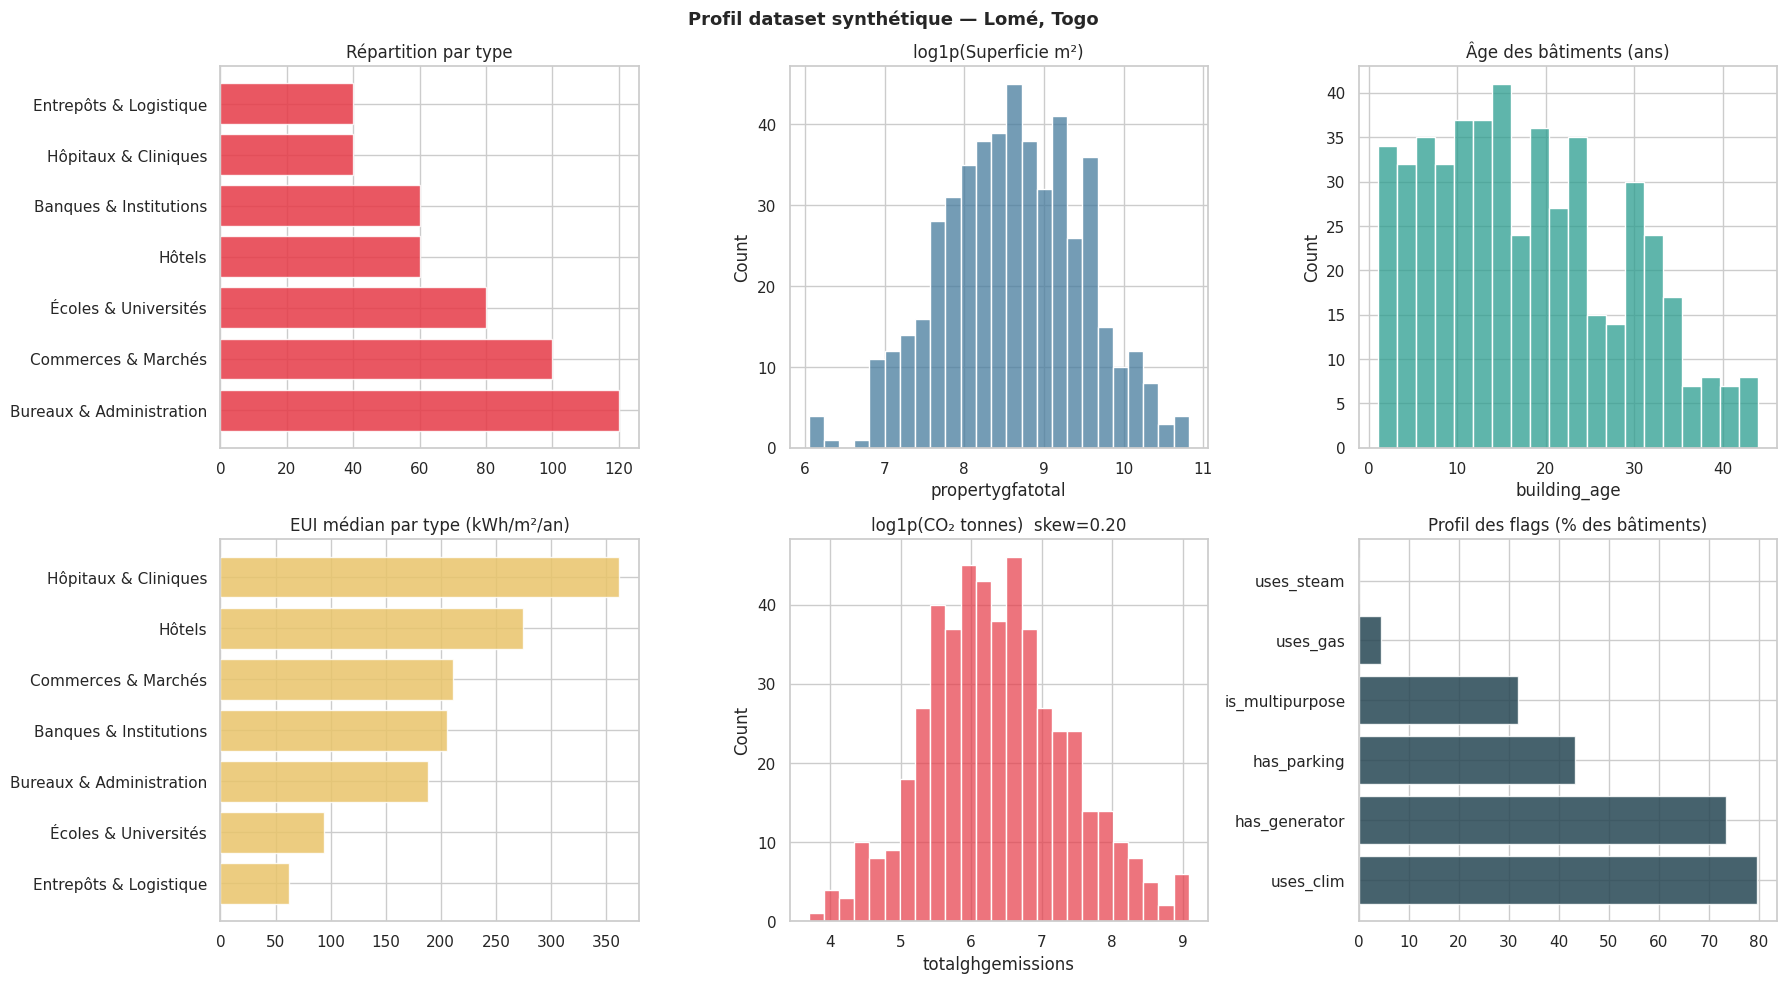

In [3]:
print('=== PROFIL DU DATASET LOMÉ ===')
display(df_lome[['propertygfatotal','building_age','eui_kwh_m2_an',
                  'totalghgemissions','energystarscore']].describe().round(1))

print(f"  elec_ratio médiane : {df_lome['elec_ratio'].median():.3f}")
print(f"  uses_gas           : {df_lome['uses_gas'].mean()*100:.1f}%")
print(f"  uses_clim          : {df_lome['uses_clim'].mean()*100:.0f}%")
print(f"  has_generator      : {df_lome['has_generator'].mean()*100:.0f}%")
print(f"  Facteur CO₂ réseau : {df_lome['emission_factor_grid'].mean():.3f} kgCO₂/kWh")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Profil dataset synthétique — Lomé, Togo', fontsize=13, fontweight='bold')

type_counts = df_lome['primarypropertytype'].value_counts()
axes[0,0].barh(type_counts.index, type_counts.values, color='#e63946', alpha=0.85)
axes[0,0].set_title('Répartition par type')

sns.histplot(np.log1p(df_lome['propertygfatotal']), bins=25, ax=axes[0,1], color='#457b9d')
axes[0,1].set_title('log1p(Superficie m²)')

sns.histplot(df_lome['building_age'], bins=20, ax=axes[0,2], color='#2a9d8f')
axes[0,2].set_title('Âge des bâtiments (ans)')

eui_by_type = df_lome.groupby('primarypropertytype')['eui_kwh_m2_an'].median().sort_values()
axes[1,0].barh(eui_by_type.index, eui_by_type.values, color='#e9c46a', alpha=0.85)
axes[1,0].set_title('EUI médian par type (kWh/m²/an)')

sns.histplot(np.log1p(df_lome['totalghgemissions']), bins=25, ax=axes[1,1], color='#e63946', alpha=0.7)
axes[1,1].set_title(f'log1p(CO₂ tonnes)  skew={np.log1p(df_lome["totalghgemissions"]).skew():.2f}')

flags = pd.Series({
    'uses_clim'    : df_lome['uses_clim'].mean()*100,
    'has_generator': df_lome['has_generator'].mean()*100,
    'has_parking'  : df_lome['has_parking'].mean()*100,
    'is_multipurpose': df_lome['is_multipurpose'].mean()*100,
    'uses_gas'     : df_lome['uses_gas'].mean()*100,
    'uses_steam'   : df_lome['uses_steam'].mean()*100,
})
axes[1,2].barh(flags.index, flags.values, color='#264653', alpha=0.85)
axes[1,2].set_title('Profil des flags (% des bâtiments)')

plt.tight_layout()
plt.show()

---
###  Comparaison des distributions Seattle vs Lomé

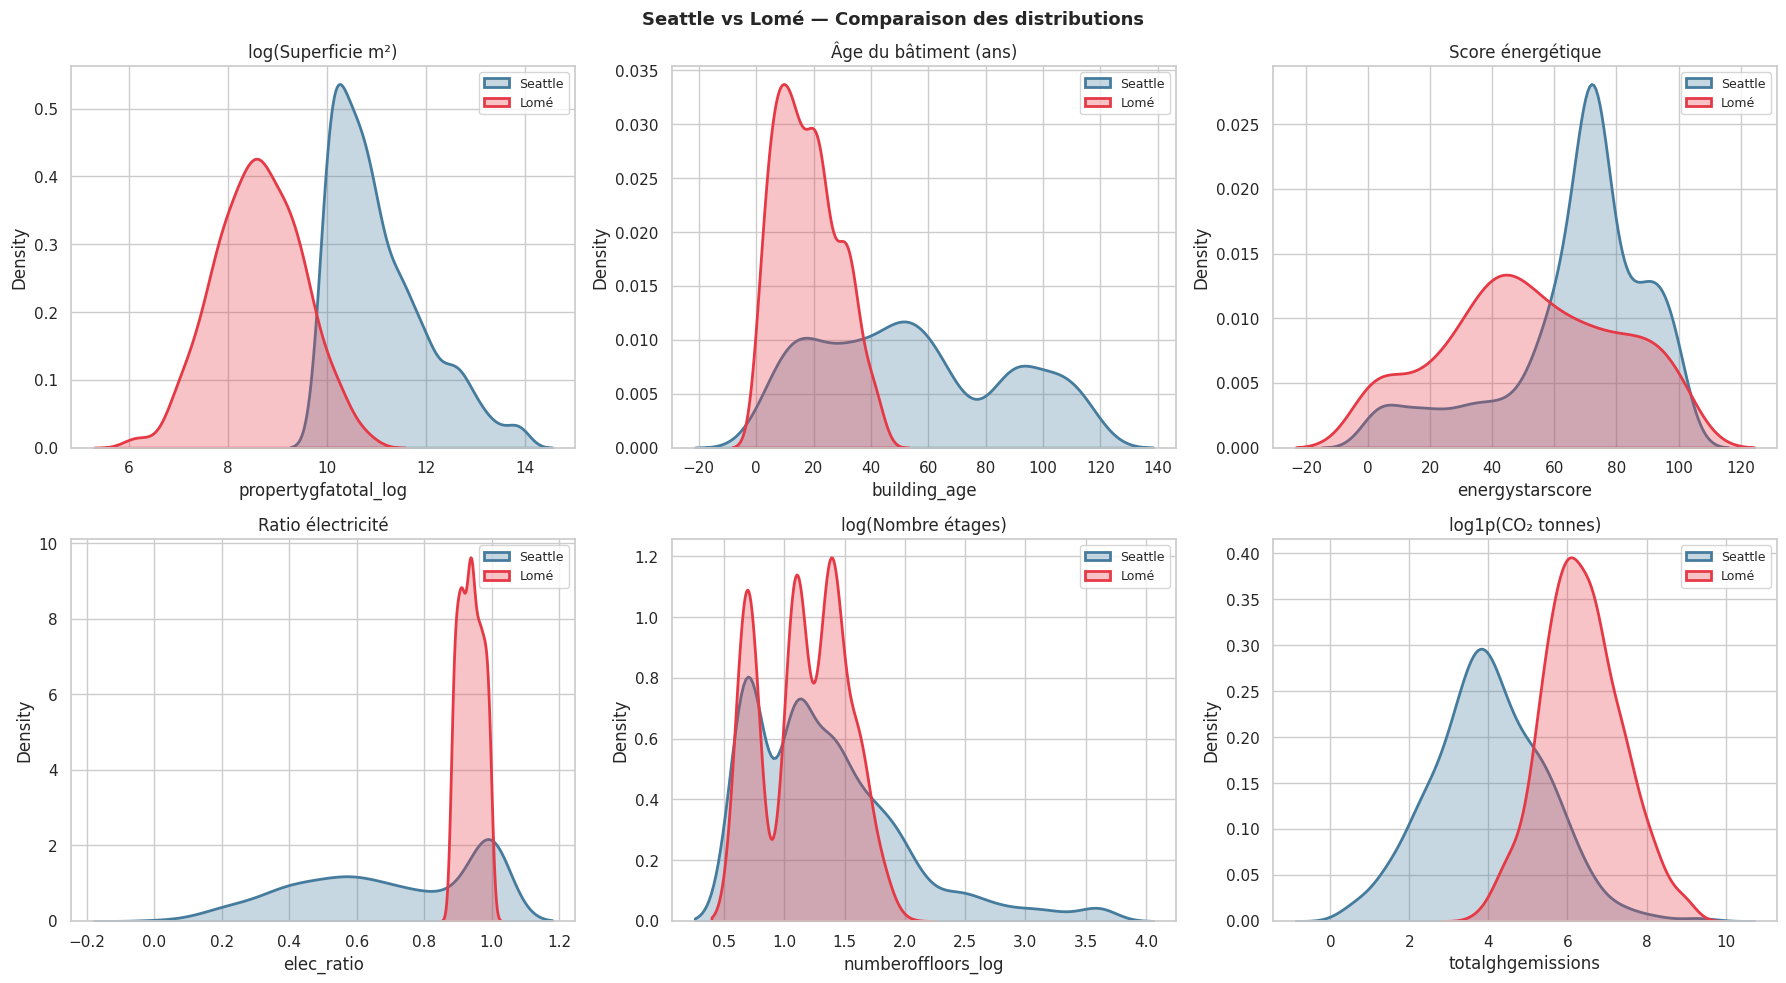

Différences clés :
  elec_ratio                Seattle:0.70  Lomé:0.94
  building_age              Seattle:51.00 ans  Lomé:17.00 ans
  energystarscore           Seattle:72.00pts  Lomé:50.50pts
  uses_gas                  Seattle:N/A  Lomé:4%


In [4]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Seattle vs Lomé — Comparaison des distributions',
             fontsize=13, fontweight='bold')

COLOR_SEA = '#457b9d'
COLOR_LOM = '#e63946'

comparisons = [
    ('propertygfatotal_log', 'propertygfatotal_log', 'log(Superficie m²)'),
    ('building_age',         'building_age',          'Âge du bâtiment (ans)'),
    ('energystarscore',      'energystarscore',        'Score énergétique'),
    ('elec_ratio',           'elec_ratio',             'Ratio électricité'),
    ('numberoffloors_log',   'numberoffloors_log',     'log(Nombre étages)'),
]

for ax, (col_s, col_l, title) in zip(axes.flat[:5], comparisons):
    data_s = df_seattle[col_s].dropna() if col_s in df_seattle.columns else pd.Series()
    data_l = df_lome[col_l].dropna()    if col_l in df_lome.columns    else pd.Series()
    if len(data_s): sns.kdeplot(data_s, ax=ax, color=COLOR_SEA, lw=2, label='Seattle', fill=True, alpha=0.3)
    if len(data_l): sns.kdeplot(data_l, ax=ax, color=COLOR_LOM, lw=2, label='Lomé',    fill=True, alpha=0.3)
    ax.set_title(title)
    ax.legend(fontsize=9)

# CO2 en log
ax = axes.flat[5]
sns.kdeplot(np.log1p(df_seattle[TARGET].dropna()), ax=ax, color=COLOR_SEA,
            lw=2, label='Seattle', fill=True, alpha=0.3)
sns.kdeplot(np.log1p(df_lome[TARGET].dropna()), ax=ax, color=COLOR_LOM,
            lw=2, label='Lomé', fill=True, alpha=0.3)
ax.set_title('log1p(CO₂ tonnes)')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

print('Différences clés :')
for col, unit in [('elec_ratio',''), ('building_age',' ans'), ('energystarscore','pts')]:
    sea_med = df_seattle[col].median() if col in df_seattle.columns else float('nan')
    lom_med = df_lome[col].median()    if col in df_lome.columns    else float('nan')
    print(f"  {col:<25} Seattle:{sea_med:.2f}{unit}  Lomé:{lom_med:.2f}{unit}")

# Safely print 'uses_gas' comparison
sea_uses_gas = f"{df_seattle['uses_gas'].mean()*100:.0f}%" if 'uses_gas' in df_seattle.columns else 'N/A'
lom_uses_gas = f"{df_lome['uses_gas'].mean()*100:.0f}%" if 'uses_gas' in df_lome.columns else 'N/A'
print(f"  {'uses_gas':<25} Seattle:{sea_uses_gas}  Lomé:{lom_uses_gas}")

---
### Préparation des features communes

In [5]:
# Features présentes dans les deux datasets
COMMON_FEATURES = [
    'propertygfatotal_log', 'numberoffloors_log', 'building_age',
    'energystarscore', 'energystar_missing',
    'elec_ratio', 'uses_gas', 'uses_steam', 'steam_ratio',
    'has_parking', 'is_multipurpose',
]

# Features spécifiques à Lomé (nouvelles informations contextuelles)
LOME_SPECIFIC = ['uses_clim', 'has_generator', 'eui_kwh_m2_an', 'emission_factor_grid']

# Garder seulement les colonnes disponibles dans les deux
available = [c for c in COMMON_FEATURES
             if c in df_seattle.columns and c in df_lome.columns]
missing = [c for c in COMMON_FEATURES if c not in df_seattle.columns or c not in df_lome.columns]
if missing: print(f'Colonnes manquantes (ignorées) : {missing}')

# Encoder le type de bâtiment sur l'union des deux datasets
le = LabelEncoder()
all_types = sorted(set(
    df_seattle['primarypropertytype'].dropna().tolist() +
    df_lome['primarypropertytype'].dropna().tolist()
))
le.fit(all_types)
df_seattle['type_encoded'] = le.transform(df_seattle['primarypropertytype'].fillna('Other'))
df_lome['type_encoded']    = le.transform(df_lome['primarypropertytype'].fillna('Other'))

FEATURES        = available + ['type_encoded']
FEATURES_STACKED = FEATURES + LOME_SPECIFIC  # pour l'approche B

print(f'Features communes           : {len(FEATURES)}')
print(f'Features stacking (A+Lomé)  : {len(FEATURES_STACKED)}')
print(f'Features communes : {FEATURES}')
print(f'Features Lomé spécifiques   : {LOME_SPECIFIC}')

Colonnes manquantes (ignorées) : ['uses_gas']
Features communes           : 11
Features stacking (A+Lomé)  : 15
Features communes : ['propertygfatotal_log', 'numberoffloors_log', 'building_age', 'energystarscore', 'energystar_missing', 'elec_ratio', 'uses_steam', 'steam_ratio', 'has_parking', 'is_multipurpose', 'type_encoded']
Features Lomé spécifiques   : ['uses_clim', 'has_generator', 'eui_kwh_m2_an', 'emission_factor_grid']


---
###  Approche A — Fine-tuning

Réentraîner un modèle XGBoost **uniquement sur Lomé**.
Pour compenser le petit dataset (500 lignes) : régularisation plus forte,
profondeur réduite, et validation 10-fold.

In [6]:
X_lome = df_lome[FEATURES].fillna(0)
y_lome = np.log1p(df_lome[TARGET])

X_tr_A, X_te_A, y_tr_A, y_te_A = train_test_split(
    X_lome, y_lome, test_size=0.25, random_state=SEED
)
y_te_A_real = np.expm1(y_te_A)
print(f'Fine-tuning — Train:{len(X_tr_A)}  Test:{len(X_te_A)}')

model_A = xgb.XGBRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.5, reg_lambda=2.0, min_child_weight=5,
    random_state=SEED, n_jobs=-1, verbosity=0
)
model_A.fit(X_tr_A, y_tr_A)

y_pred_A      = model_A.predict(X_te_A)
y_pred_A_real = np.expm1(y_pred_A)

r2_A    = r2_score(y_te_A, y_pred_A)
mape_A  = np.mean(np.abs((y_te_A_real - y_pred_A_real) / y_te_A_real.clip(lower=1))) * 100
mdape_A = np.median(np.abs((y_te_A_real - y_pred_A_real) / y_te_A_real.clip(lower=1))) * 100
cv_A    = cross_val_score(model_A, X_lome, y_lome,
                          cv=KFold(10, shuffle=True, random_state=SEED), scoring='r2')

print(f'\nApproche A — Fine-tuning :')
print(f'  R² test       : {r2_A:.4f}')
print(f'  CV R² 10-fold : {cv_A.mean():.4f} +/- {cv_A.std():.4f}')
print(f'  MAPE          : {mape_A:.2f}%')
print(f'  MdAPE         : {mdape_A:.2f}%')

Fine-tuning — Train:375  Test:125

Approche A — Fine-tuning :
  R² test       : 0.9322
  CV R² 10-fold : 0.9497 +/- 0.0122
  MAPE          : 21.00%
  MdAPE         : 14.92%


---
###  Approche B — Stacking

La prédiction du modèle Seattle devient une **feature supplémentaire**.
Le biais entre Seattle et Lomé est aussi ajouté comme feature — il encode
la distance contextuelle entre les deux villes.

```
X_lomé → [Modèle Seattle] → pred_seattle (log CO₂)
X_lomé + pred_seattle + biais + features_lomé → [Méta-modèle XGBoost] → pred_finale
```

In [7]:
# 1. Entraîner le modèle Seattle sur les features communes
X_sea = df_seattle[FEATURES].fillna(0)
y_sea = np.log1p(df_seattle[TARGET])

seattle_model = xgb.XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    random_state=SEED, n_jobs=-1, verbosity=0
)
seattle_model.fit(X_sea, y_sea)
print('Modèle Seattle entraîné sur features communes.')

# 2. Prédictions Seattle sur Lomé
seattle_preds = seattle_model.predict(X_lome.values)
biais_moyen   = (seattle_preds - y_lome.values).mean()
print(f'\nBiais Seattle → Lomé (espace log) : {biais_moyen:+.3f}')
if biais_moyen > 0:
    print('  → Seattle SURESTIME les émissions CO₂ à Lomé')
else:
    print('  → Seattle SOUS-ESTIME les émissions CO₂ à Lomé')
print('  (attendu : sous-estimation car réseau électrique beaucoup plus carboné à Lomé)')

# 3. Construire X_stacked
X_stacked = X_lome.copy()
X_stacked['seattle_pred_log'] = seattle_preds            # prédiction Seattle
X_stacked['seattle_biais']    = seattle_preds - y_lome.values  # correction nécessaire

# Ajouter les features spécifiques Lomé
for col in LOME_SPECIFIC:
    if col in df_lome.columns:
        X_stacked[col] = df_lome[col].values

print(f'\nX_stacked : {X_stacked.shape[1]} features')
print(f'  Dont : seattle_pred_log, seattle_biais, {LOME_SPECIFIC}')

# 4. Même split pour comparaison équitable
# On utilise les mêmes indices que l'approche A
X_tr_B = X_stacked.iloc[X_tr_A.index]
X_te_B = X_stacked.iloc[X_te_A.index]
y_tr_B, y_te_B = y_tr_A, y_te_A
y_te_B_real = y_te_A_real

# 5. Méta-modèle Lomé
model_B = xgb.XGBRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.3, reg_lambda=1.5,
    random_state=SEED, n_jobs=-1, verbosity=0
)
model_B.fit(X_tr_B, y_tr_B)

y_pred_B      = model_B.predict(X_te_B)
y_pred_B_real = np.expm1(y_pred_B)

r2_B    = r2_score(y_te_B, y_pred_B)
mape_B  = np.mean(np.abs((y_te_B_real - y_pred_B_real) / y_te_B_real.clip(lower=1))) * 100
mdape_B = np.median(np.abs((y_te_B_real - y_pred_B_real) / y_te_B_real.clip(lower=1))) * 100
cv_B    = cross_val_score(model_B, X_stacked, y_lome,
                          cv=KFold(10, shuffle=True, random_state=SEED), scoring='r2')

print(f'\nApproche B — Stacking :')
print(f'  R² test       : {r2_B:.4f}')
print(f'  CV R² 10-fold : {cv_B.mean():.4f} +/- {cv_B.std():.4f}')
print(f'  MAPE          : {mape_B:.2f}%')
print(f'  MdAPE         : {mdape_B:.2f}%')

Modèle Seattle entraîné sur features communes.

Biais Seattle → Lomé (espace log) : -4.121
  → Seattle SOUS-ESTIME les émissions CO₂ à Lomé
  (attendu : sous-estimation car réseau électrique beaucoup plus carboné à Lomé)

X_stacked : 17 features
  Dont : seattle_pred_log, seattle_biais, ['uses_clim', 'has_generator', 'eui_kwh_m2_an', 'emission_factor_grid']

Approche B — Stacking :
  R² test       : 0.9832
  CV R² 10-fold : 0.9882 +/- 0.0047
  MAPE          : 9.27%
  MdAPE         : 6.23%


---
###  Comparaison A vs B + analyse des résidus

=== COMPARAISON APPROCHE A vs B ===


,R2 test,CV R2 mean,CV R2 std,MAPE (%),MdAPE (%),Knowledge Seattle,Features Lomé specifiques
Approche,,,,,,,
A — Fine-tuning,0.9322,0.9497,0.0122,21.00%,14.92%,Non,Non
B — Stacking,0.9832,0.9882,0.0047,9.27%,6.23%,Oui,Oui


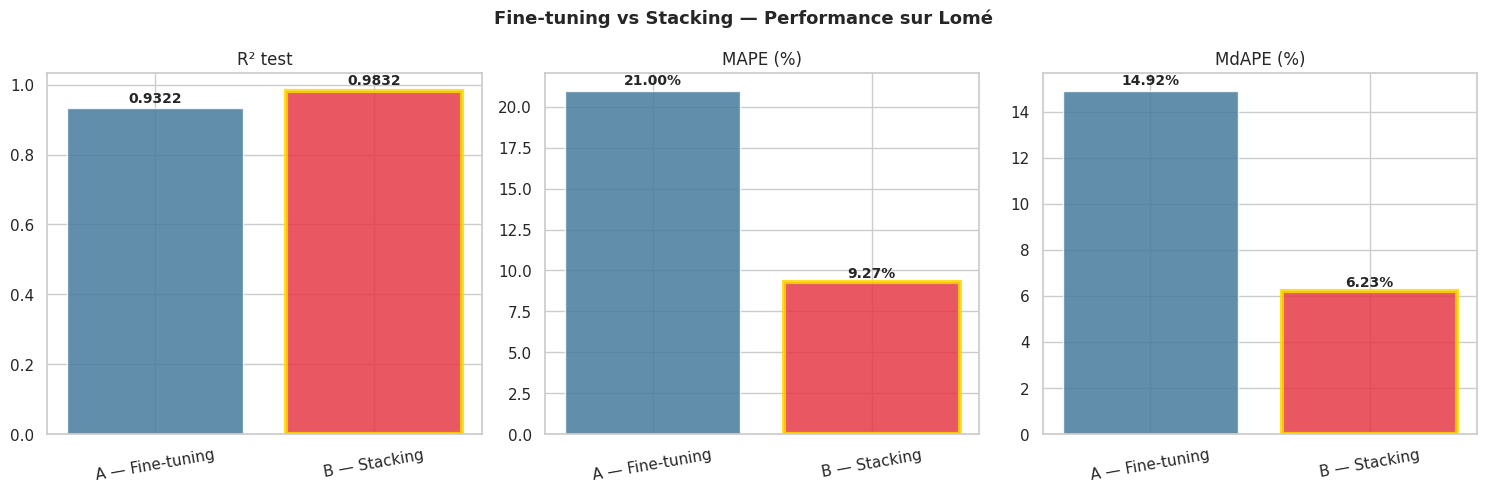


Meilleure approche : B


In [8]:
# Tableau comparatif
comp_df = pd.DataFrame([
    {'Approche': 'A — Fine-tuning', 'R2 test': r2_A,
     'CV R2 mean': cv_A.mean(), 'CV R2 std': cv_A.std(),
     'MAPE (%)': mape_A, 'MdAPE (%)': mdape_A,
     'Knowledge Seattle': 'Non', 'Features Lomé specifiques': 'Non'},
    {'Approche': 'B — Stacking', 'R2 test': r2_B,
     'CV R2 mean': cv_B.mean(), 'CV R2 std': cv_B.std(),
     'MAPE (%)': mape_B, 'MdAPE (%)': mdape_B,
     'Knowledge Seattle': 'Oui', 'Features Lomé specifiques': 'Oui'},
]).set_index('Approche')

print('=== COMPARAISON APPROCHE A vs B ===')
display(comp_df.style
    .background_gradient(cmap='RdYlGn', subset=['R2 test','CV R2 mean'], vmin=0.7, vmax=1.0)
    .background_gradient(cmap='RdYlGn_r', subset=['MAPE (%)','MdAPE (%)'])
    .format({'R2 test':'{:.4f}','CV R2 mean':'{:.4f}','CV R2 std':'{:.4f}',
             'MAPE (%)':'{:.2f}%','MdAPE (%)':'{:.2f}%'})
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Fine-tuning vs Stacking — Performance sur Lomé', fontsize=13, fontweight='bold')
colors = ['#457b9d','#e63946']
for ax, (metric, label) in zip(axes, [
    ('R2 test','R² test'), ('MAPE (%)','MAPE (%)'), ('MdAPE (%)','MdAPE (%)')
]):
    vals = comp_df[metric]
    best = vals.max() if metric == 'R2 test' else vals.min()
    bars = ax.bar(vals.index, vals.values, color=colors, alpha=0.85)
    for bar, v in zip(bars, vals.values):
        if v == best: bar.set_edgecolor('gold'); bar.set_linewidth(3)
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()*1.01,
                f'{v:.4f}' if metric=='R2 test' else f'{v:.2f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.set_title(label)
    ax.set_xticklabels(vals.index, rotation=10)
plt.tight_layout()
plt.show()

# Sélection du meilleur
best_approach = 'B' if r2_B >= r2_A else 'A'
best_model    = model_B if best_approach == 'B' else model_A
X_best_te     = X_te_B  if best_approach == 'B' else X_te_A
y_best_te     = y_te_B  if best_approach == 'B' else y_te_A
r2_best       = r2_B    if best_approach == 'B' else r2_A
mape_best     = mape_B  if best_approach == 'B' else mape_A
mdape_best    = mdape_B if best_approach == 'B' else mdape_A
print(f'\nMeilleure approche : {best_approach}')

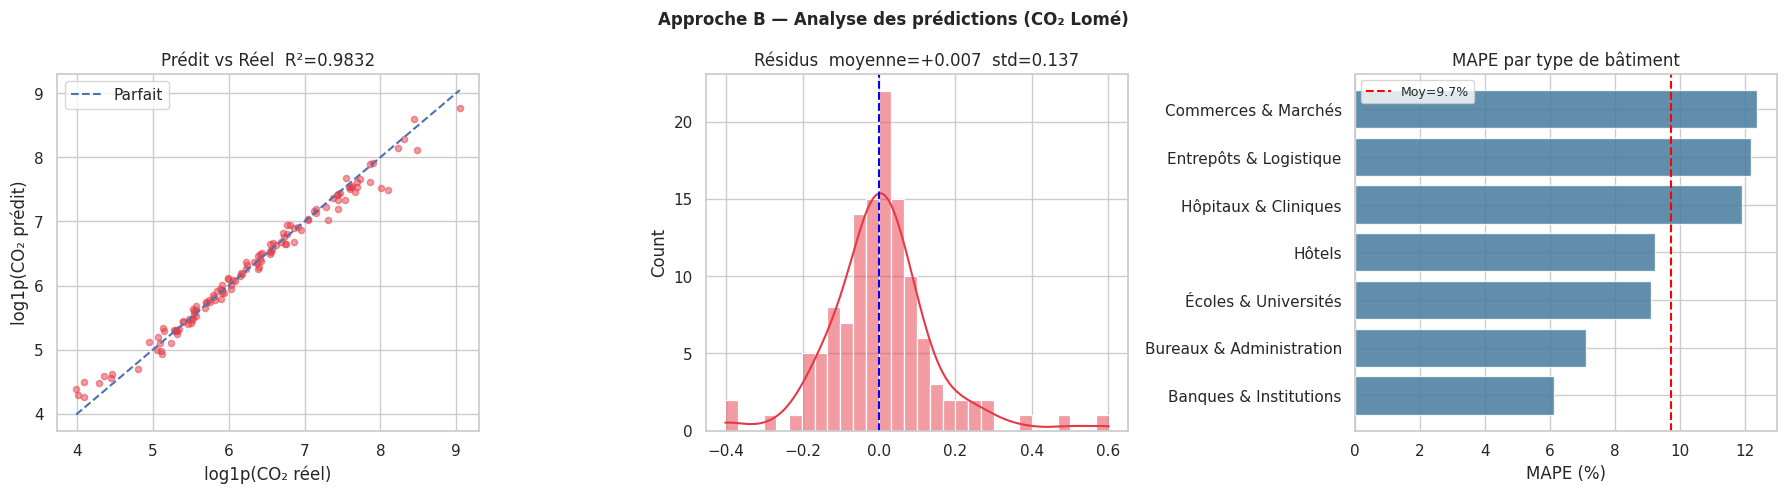

% résidus dans [-2σ, +2σ] : 93.6%


In [9]:
# Analyse des résidus du meilleur modèle
y_pred_best      = best_model.predict(X_best_te)
y_pred_best_real = np.expm1(y_pred_best)
y_best_real      = np.expm1(y_best_te)
residuals        = y_best_te.values - y_pred_best

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'Approche {best_approach} — Analyse des prédictions (CO₂ Lomé)',
             fontsize=12, fontweight='bold')

axes[0].scatter(y_best_te, y_pred_best, alpha=0.5, s=20, color='#e63946')
lims = [y_best_te.min(), y_best_te.max()]
axes[0].plot(lims, lims, 'b--', lw=1.5, label='Parfait')
axes[0].set_xlabel('log1p(CO₂ réel)'); axes[0].set_ylabel('log1p(CO₂ prédit)')
axes[0].set_title(f'Prédit vs Réel  R²={r2_score(y_best_te, y_pred_best):.4f}')
axes[0].legend()

sns.histplot(residuals, bins=30, kde=True, ax=axes[1], color='#e63946')
axes[1].axvline(0, color='blue', linestyle='--', lw=1.5)
axes[1].set_title(f'Résidus  moyenne={residuals.mean():+.3f}  std={residuals.std():.3f}')

# MAPE par type de bâtiment
types_test = df_lome.loc[X_best_te.index, 'primarypropertytype'].values
ape_df = pd.DataFrame({'type': types_test,
    'ape': np.abs((y_best_real.values - y_pred_best_real) / y_best_real.values.clip(min=1))*100
}).groupby('type')['ape'].mean().sort_values()

axes[2].barh(ape_df.index, ape_df.values, color='#457b9d', alpha=0.85)
axes[2].axvline(ape_df.mean(), color='red', linestyle='--', lw=1.5,
                label=f'Moy={ape_df.mean():.1f}%')
axes[2].set_title('MAPE par type de bâtiment')
axes[2].set_xlabel('MAPE (%)')
axes[2].legend(fontsize=9)

plt.tight_layout()
plt.show()

print(f'% résidus dans [-2σ, +2σ] : {(np.abs(residuals) < 2*residuals.std()).mean()*100:.1f}%')

---
###  Analyse SHAP — Quelles features comptent à Lomé ?

On attend que `emission_factor_grid`, `uses_clim` et `has_generator`
apparaissent dans le top si l'approche B est retenue — c'est la validation
que le modèle a bien appris les spécificités du contexte Lomé.

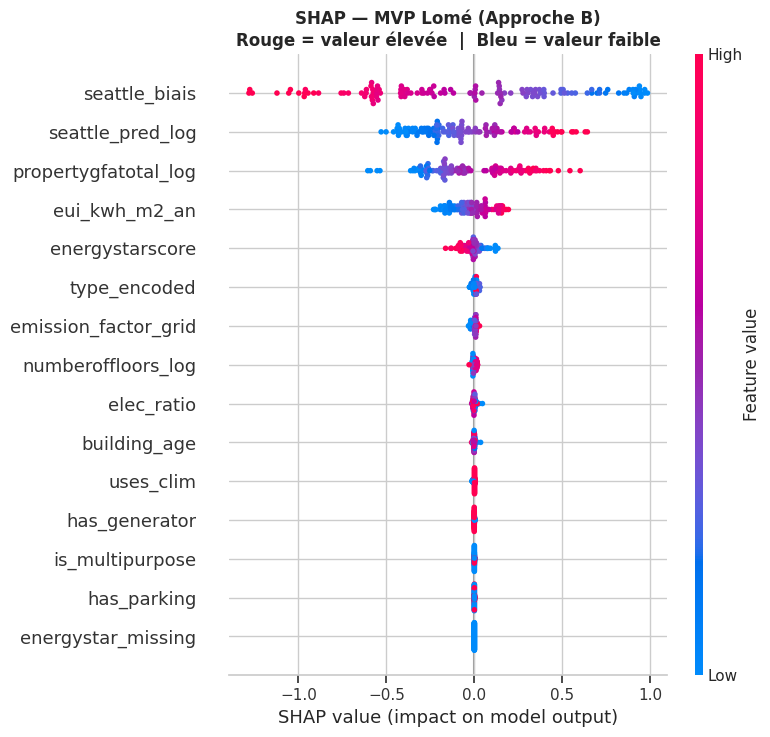

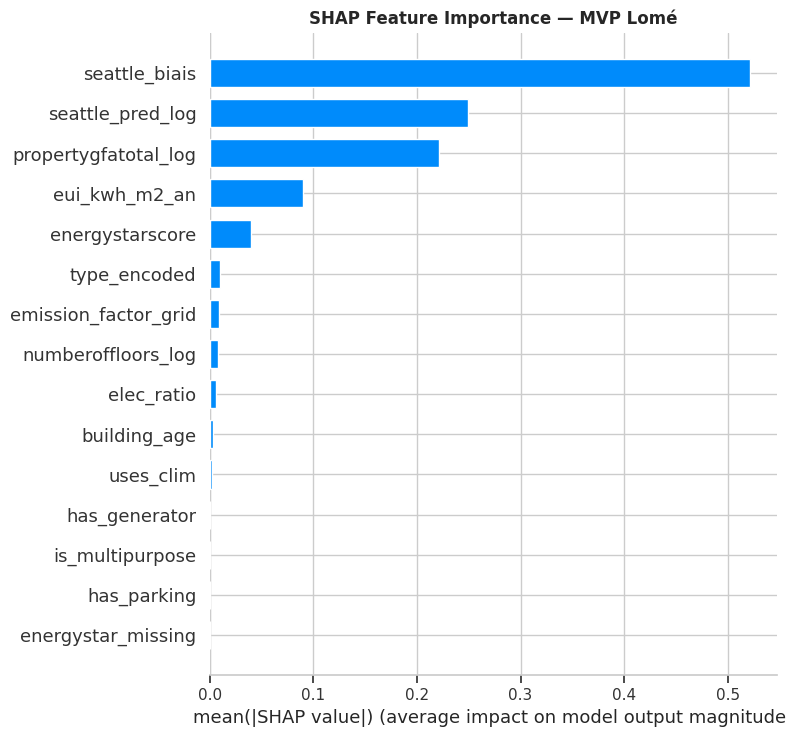

Top 12 features — MVP Lomé :


,Feature,Importance SHAP,Effet moyen,Direction
12,seattle_biais,0.5213,-0.0192,Diminue CO₂
11,seattle_pred_log,0.2497,-0.0406,Diminue CO₂
0,propertygfatotal_log,0.2215,-0.0179,Diminue CO₂
15,eui_kwh_m2_an,0.0902,-0.0190,Diminue CO₂
3,energystarscore,0.0401,-0.0123,Diminue CO₂
10,type_encoded,0.0096,+0.0012,Augmente CO₂
16,emission_factor_grid,0.0087,+0.0031,Augmente CO₂
1,numberoffloors_log,0.0082,+0.0001,Augmente CO₂
5,elec_ratio,0.0060,+0.0008,Augmente CO₂
2,building_age,0.0033,-0.0009,Diminue CO₂


In [10]:
explainer = shap.TreeExplainer(best_model)
shap_vals = explainer.shap_values(X_best_te)

plt.figure(figsize=(10, 7))
shap.summary_plot(shap_vals, X_best_te, max_display=15, plot_type='dot', show=False)
plt.title(f'SHAP — MVP Lomé (Approche {best_approach})\n'
          'Rouge = valeur élevée  |  Bleu = valeur faible',
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_vals, X_best_te, max_display=15, plot_type='bar', show=False)
plt.title(f'SHAP Feature Importance — MVP Lomé', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

shap_summary = pd.DataFrame({
    'Feature'        : X_best_te.columns,
    'Importance SHAP': np.abs(shap_vals).mean(axis=0),
    'Effet moyen'    : shap_vals.mean(axis=0),
}).sort_values('Importance SHAP', ascending=False).head(12)
shap_summary['Direction'] = shap_summary['Effet moyen'].apply(
    lambda x: 'Augmente CO₂' if x > 0 else 'Diminue CO₂'
)
print('Top 12 features — MVP Lomé :')
display(shap_summary.style
    .background_gradient(cmap='YlOrRd', subset=['Importance SHAP'])
    .format({'Importance SHAP':'{:.4f}','Effet moyen':'{:+.4f}'})
)

In [11]:
os.makedirs(MODEL_DIR, exist_ok=True)

mvp_path = f'{MODEL_DIR}mvp_lome_co2_approche{best_approach}.pkl'
joblib.dump(best_model, mvp_path)

meta = {
    'modele'                  : f'XGBoost Approche {best_approach}',
    'target'                  : TARGET,
    'contexte'                : 'Lomé, Togo',
    'features'                : list(X_best_te.columns),
    'n_train'                 : len(X_tr_A),
    'n_test'                  : len(X_te_A),
    'r2_test'                 : round(r2_best, 4),
    'mape'                    : round(mape_best, 2),
    'mdape'                   : round(mdape_best, 2),
    'emission_factor_grid'    : round(float(df_lome['emission_factor_grid'].mean()), 3),
    'statut'                  : 'MVP — dataset synthétique, à valider sur données réelles',
    'next_step'               : 'Collecter 20-30 bâtiments réels à Lomé pour validation'
}
with open(f'{MODEL_DIR}mvp_lome_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print(f'Modèle MVP sauvegardé : {mvp_path}')


Modèle MVP sauvegardé : /content/drive/MyDrive/D-CLIC/projet_energisight/models/mvp_lome_co2_approcheB.pkl
